# FLoC Cohorts from sessions data for panels stratified on race 

What are the right cohort sizes to use?

Precompute simhash and cohorts for panel samples.

In [1]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import floc

from comscore.data import read_weeks_machines_domains
import prefixLSH


## Precompute panel samples simhash

read in pre-processed sessions data

In [2]:
# read in the pre-processed sessions data 
# this maps week,machine_id -> domains set
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'
weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)
weeks_machines_domains_df.drop(['domains'], axis=1).head()

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


,machine_id,week,n_domains
0,169007206,1,104
1,170331223,1,0
2,170422065,1,20
3,170911221,1,49
4,171771316,1,64


___

read in panels that were created based on the sessions data and demographic data

attach domains data

attach the simhash computed from the domains

precompute cohorts for each panel

In [3]:
comscore_acs_race_panels_fpath = '../output/comscore_acs_race_panels.csv'
all_panels_df = pd.read_csv(comscore_acs_race_panels_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.drop(['machine_id'], axis=1).head()

read in all panels: 12568740 total rows
520 panels


,week,n_domains,racial_background,stratify,panel_id
0,1,16,1.0,1,1
1,1,12,1.0,1,1
2,1,9,1.0,1,1
3,1,17,1.0,1,1
4,1,50,1.0,1,1


In [5]:
weeks_machines_domains = weeks_machines_domains_df.set_index(['machine_id','week'])['domains']
all_panels_df['domains'] = all_panels_df.set_index(['machine_id','week']).index.map(weeks_machines_domains)
all_panels_df.drop(['machine_id','domains'], axis=1).head()

,week,n_domains,racial_background,stratify,panel_id
0,1,16,1.0,1,1
1,1,12,1.0,1,1
2,1,9,1.0,1,1
3,1,17,1.0,1,1
4,1,50,1.0,1,1


In [8]:
# apply simhash
all_panels_df['simhash'] = all_panels_df.domains.apply(floc.hashes.sim_hash_string)

#### Save intermediary output: panels with simhash

In [36]:
comscore_acs_race_panels_simhash_fpath = '../output/comscore_acs_race_panels_simhash.csv'

In [38]:
print('saving to %s...' % comscore_acs_race_panels_simhash_fpath)
all_panels_df.drop('domains', axis=1).to_csv(comscore_acs_race_panels_simhash_fpath, index=False)
# all_panels_df.to_csv(comscore_acs_race_panels_simhash_fpath, index=False)

saving to ../output/comscore_acs_race_panels_simhash.csv...


#### Script re-entry point

In [74]:
all_panels_df = pd.read_csv(comscore_acs_race_panels_simhash_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())

read in all panels: 12568740 total rows
520 panels


## Pre-compute cohorts for each panel

each sample's cohort is dependent on the rest of the simhashes in the panel

for this reason, cohorts must be computed per panel

In [75]:
# some helper functions for plotting
import math

dpi = 100
t = 0.1

race_values = {1:'white', 2:'black', 3:'asian', 5:'other'}


def get_cohort_demo_portions_df(panel_df, demo_col):
    df = panel_df.groupby(
        ['cohort', demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby('cohort').count()['panel_id']
    df['portion'] = df['count']/df['total']
    return df


def plot_cohort_demo_fractions(panel_df, demo_col, demo_value_names_dict, 
                               ncols=4, print=False):
    
    nrows = math.ceil(len(demo_value_names_dict)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), dpi=dpi)
    axes = axes.flatten()
    axes[0].set_ylabel('fraction')
    fig.tight_layout()

    cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
    demo_fractions = panel_df.groupby(demo_col)['panel_id'].count() / len(panel_df)
    
    for i, (val,name) in enumerate(demo_value_names_dict.items()):
        ax = axes[i]
        cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
        # Google's sensitivity analysis actually looked at avg for sensitive categories
        # across all users rather than across cohorts
        demo_fraction = demo_fractions[val]
        if print:
            print('mean fraction %s across cohorts = %0.2f' % (name, cohort_demo_mean))
            print('fraction %s across all users in cohorts = %0.2f' % (name, demo_fraction))
        cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")
        ax.hlines(y=demo_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        ax.hlines(y=demo_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        ax.set_xticks([])
        ax.set_xlabel('cohorts')
        #ax.set_ylabel('fraction "%s"' % name)
        ax.set_title(name)
    plt.show()
    return cohort_demo_portions_df

### Comparing values of k for cohort creation

What is a good size of k to use? The Google Chrome origin trial (OT) used k=2000 but with much larger samples than our panel.

It is important for there to be enough cohorts in order to separate the browsing histories.

e.g. for the extreme example, if we were to use k=2000 but only have 8 cohorts, then users that exhibit what would be considered very different browsing behaviors if there were more cohorts, such as in the OT trial, may instead be grouped into the same cohort. 

Here we compare various values of k before choosing values to precompute cohorts for.

In [76]:
33872 / 2000

16.936


For the OT, the number of cohorts was 33,872. i.e. More than 16.5x the minimum k.

Should we try to use a similar ratio of `k : |C| = 2 : 33.9` ?

In [77]:
panel_id = 2 # looked at various panel IDs
panel_df = all_panels_df[all_panels_df.panel_id==panel_id].copy()
print('using panel id %s' % panel_id)

using panel id 2


In [78]:
def show_panel_info(panel_df):
    print('%s total cohorts' % panel_df.cohort.nunique())
    print('|C| / k = %0.3f' % (panel_df.cohort.nunique()/k))
    
    print('cohort sizes:')
    cohort_counts = panel_df['cohort'].value_counts()
    print(cohort_counts.describe())

    fig,ax = plt.subplots(2,1,figsize=(4,3), sharex=True, dpi=100)
    cohort_counts.hist(ax=ax[0])
    ax[0].set_ylabel('cohorts')
    ax[1].set_ylabel('cohorts')
    _ = ax[1].set_xlabel('cohort size')
    _ = cohort_counts.hist(ax=ax[1], bins=50)
    
    _ = plot_cohort_demo_fractions(panel_df, 'racial_background', race_values)


k=2000 ---------------------------

8 total cohorts
|C| / k = 0.004
cohort sizes:
count       8.000000
mean     3291.750000
std       620.706222
min      2513.000000
25%      2798.750000
50%      3165.000000
75%      3855.500000
max      4108.000000
Name: cohort, dtype: float64


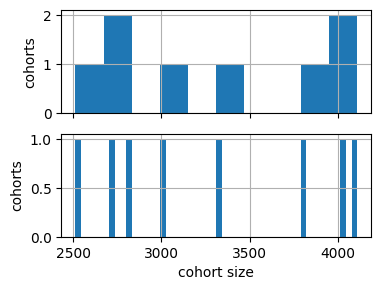

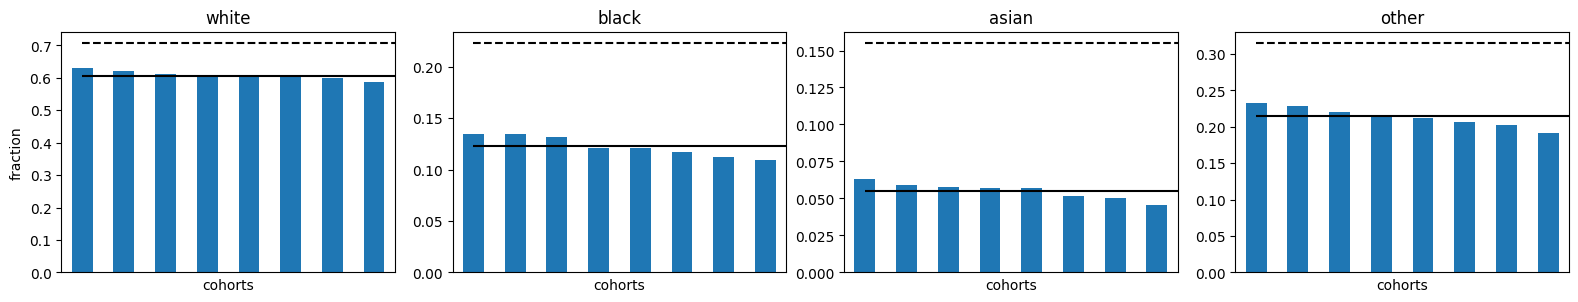


k=1000 ---------------------------

17 total cohorts
|C| / k = 0.017
cohort sizes:
count      17.000000
mean     1549.058824
std       482.057241
min      1062.000000
25%      1262.000000
50%      1381.000000
75%      1758.000000
max      2735.000000
Name: cohort, dtype: float64


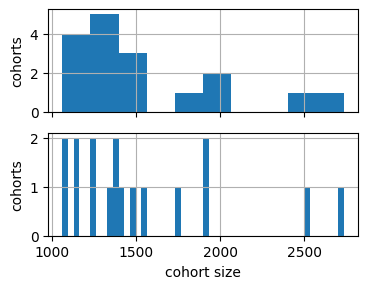

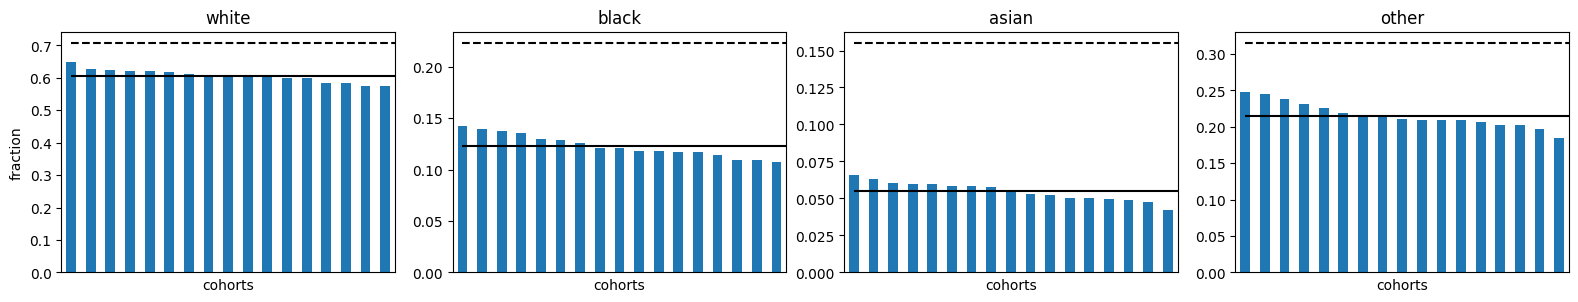


k=500 ---------------------------

33 total cohorts
|C| / k = 0.066
cohort sizes:
count      33.000000
mean      798.000000
std       197.585266
min       520.000000
25%       645.000000
50%       785.000000
75%       925.000000
max      1262.000000
Name: cohort, dtype: float64


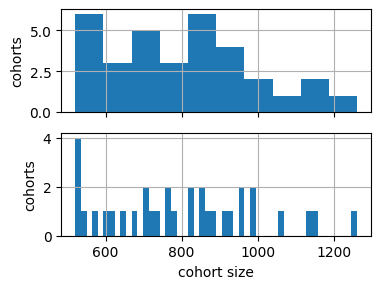

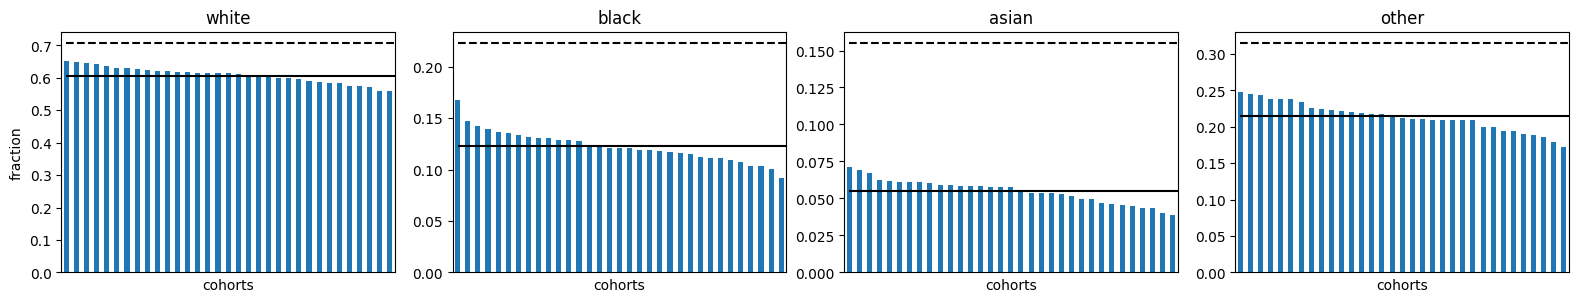


k=250 ---------------------------

64 total cohorts
|C| / k = 0.256
cohort sizes:
count     64.000000
mean     411.468750
std       98.542066
min      262.000000
25%      325.500000
50%      399.000000
75%      492.250000
max      637.000000
Name: cohort, dtype: float64


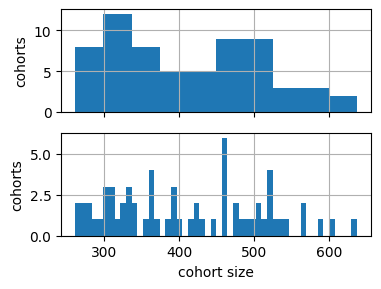

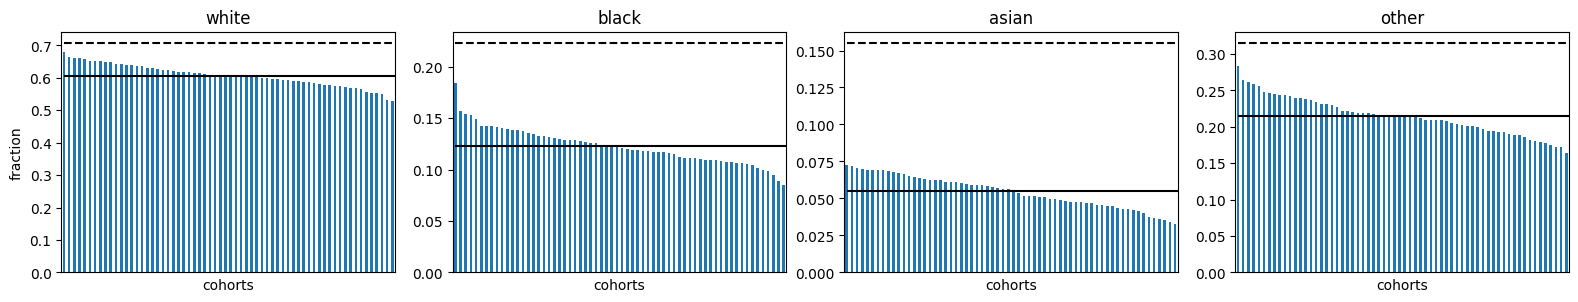


k=125 ---------------------------

138 total cohorts
|C| / k = 1.104
cohort sizes:
count    138.000000
mean     190.826087
std       44.397987
min      125.000000
25%      154.000000
50%      184.500000
75%      215.000000
max      308.000000
Name: cohort, dtype: float64


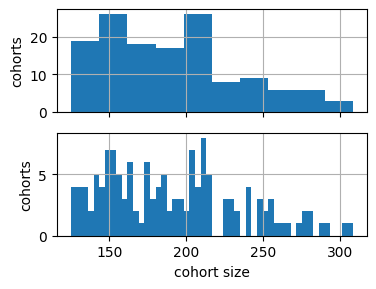

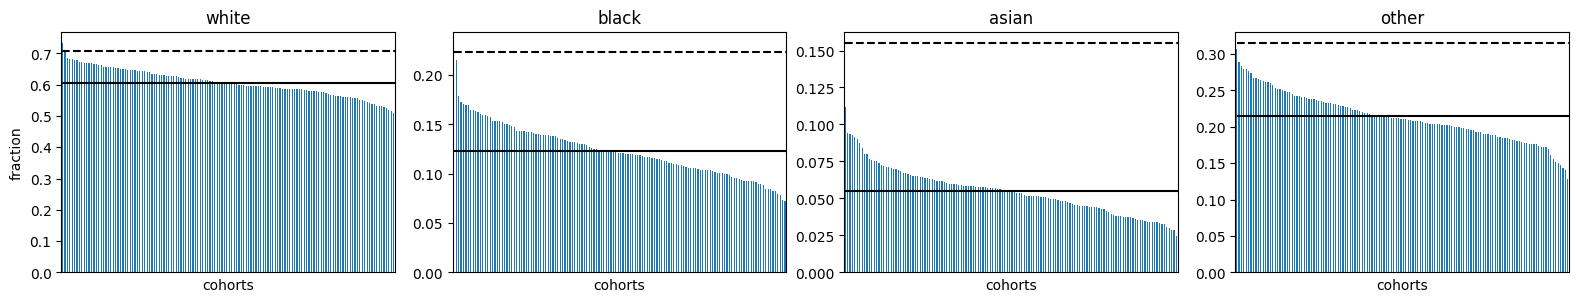


k=100 ---------------------------

167 total cohorts
|C| / k = 1.670
cohort sizes:
count    167.000000
mean     157.688623
std       36.965941
min      100.000000
25%      126.500000
50%      152.000000
75%      185.000000
max      262.000000
Name: cohort, dtype: float64


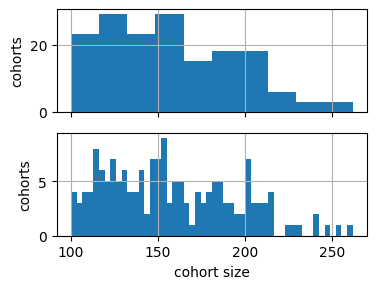

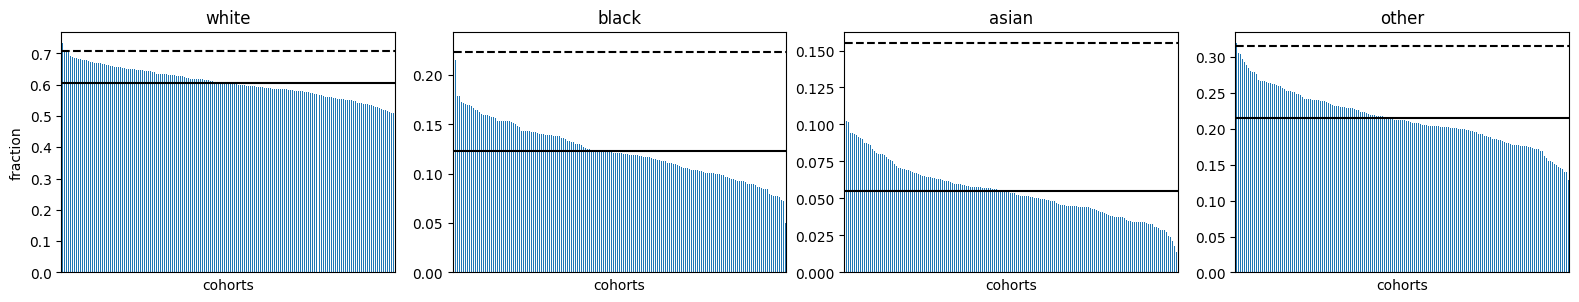


k=50 ---------------------------

307 total cohorts
|C| / k = 6.140
cohort sizes:
count    307.000000
mean      85.778502
std       25.490415
min       50.000000
25%       65.000000
50%       81.000000
75%      101.000000
max      174.000000
Name: cohort, dtype: float64


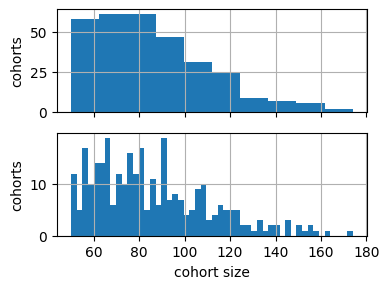

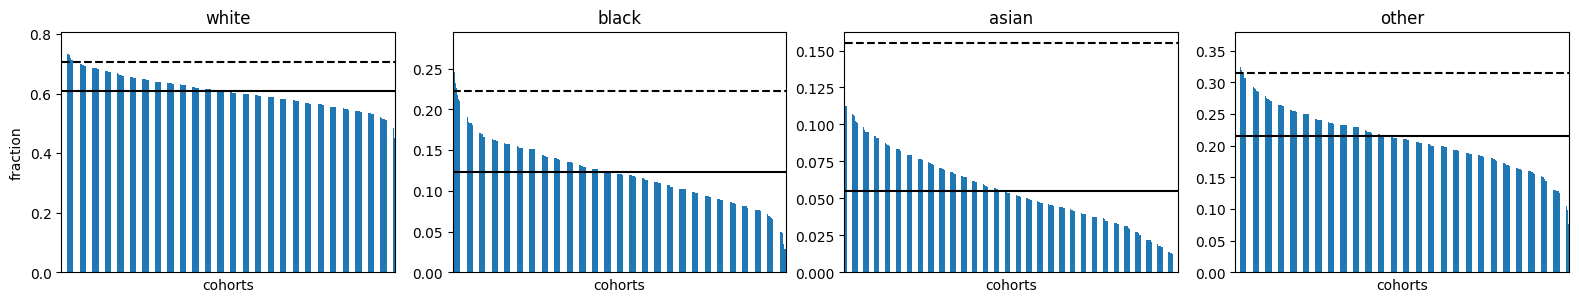


k=40 ---------------------------

404 total cohorts
|C| / k = 10.100
cohort sizes:
count    404.000000
mean      65.183168
std       19.727451
min       40.000000
25%       49.000000
50%       63.000000
75%       77.000000
max      156.000000
Name: cohort, dtype: float64


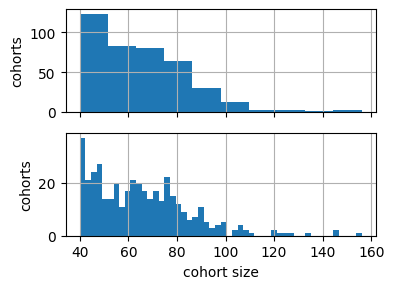

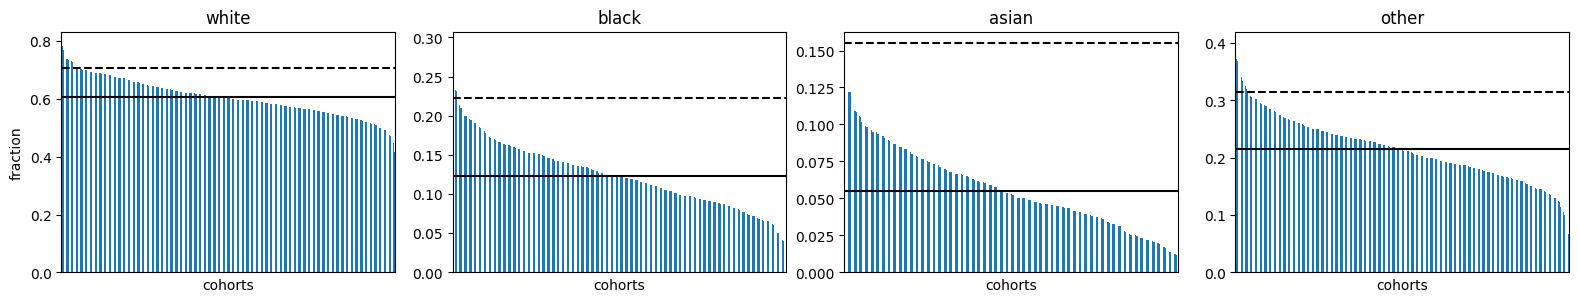


k=35 ---------------------------

466 total cohorts
|C| / k = 13.314
cohort sizes:
count    466.000000
mean      56.510730
std       16.529703
min       35.000000
25%       43.000000
50%       54.000000
75%       67.000000
max      128.000000
Name: cohort, dtype: float64


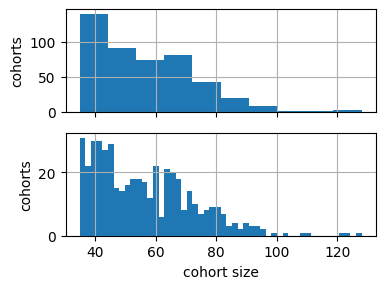

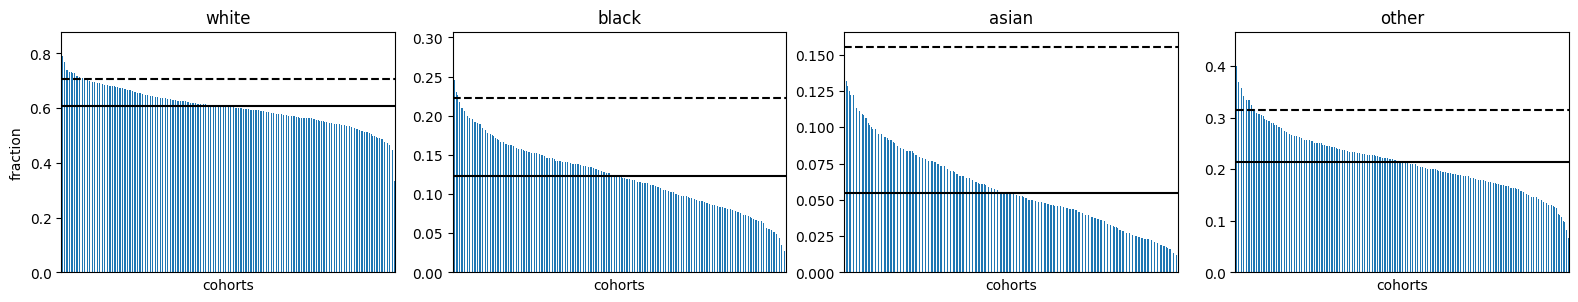


k=32 ---------------------------

503 total cohorts
|C| / k = 15.719
cohort sizes:
count    503.000000
mean      52.353877
std       14.887694
min       32.000000
25%       40.500000
50%       49.000000
75%       62.500000
max      121.000000
Name: cohort, dtype: float64


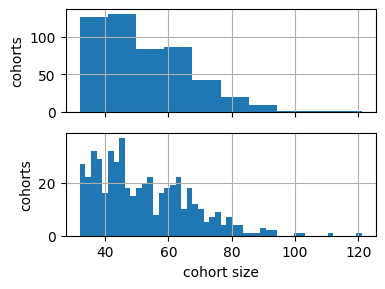

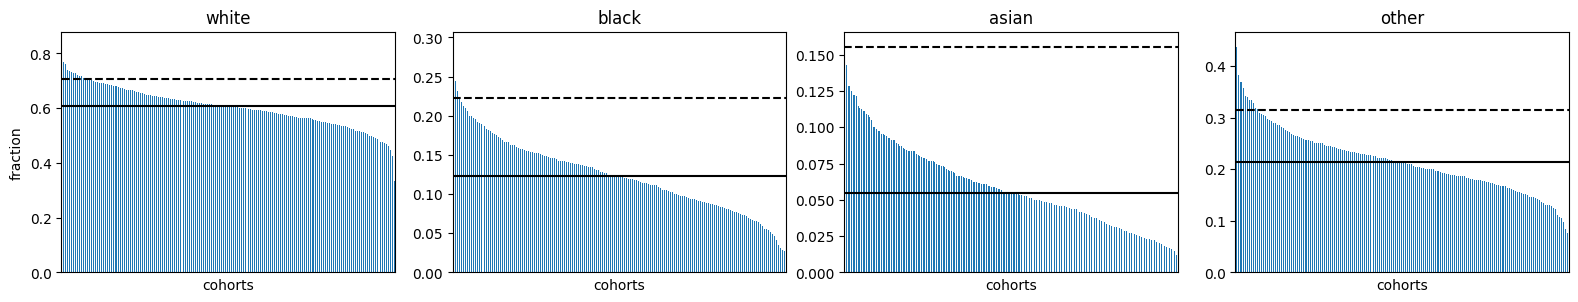


k=31 ---------------------------

526 total cohorts
|C| / k = 16.968
cohort sizes:
count    526.000000
mean      50.064639
std       14.305231
min       31.000000
25%       39.000000
50%       47.000000
75%       60.000000
max      121.000000
Name: cohort, dtype: float64


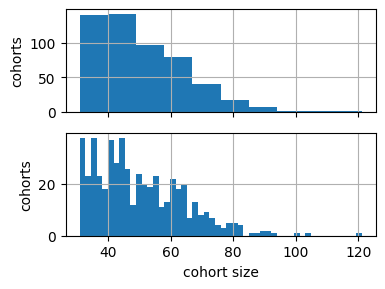

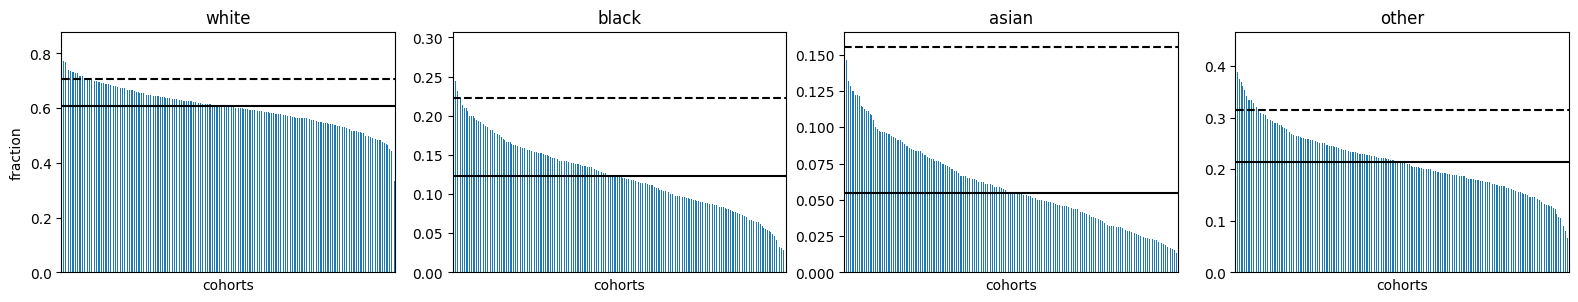


k=30 ---------------------------

551 total cohorts
|C| / k = 18.367
cohort sizes:
count    551.000000
mean      47.793103
std       13.538794
min       30.000000
25%       37.000000
50%       45.000000
75%       56.000000
max      103.000000
Name: cohort, dtype: float64


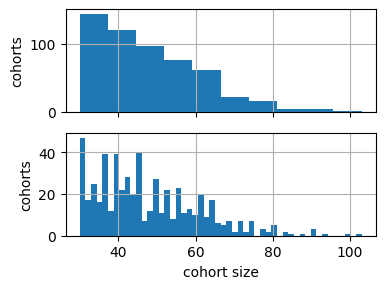

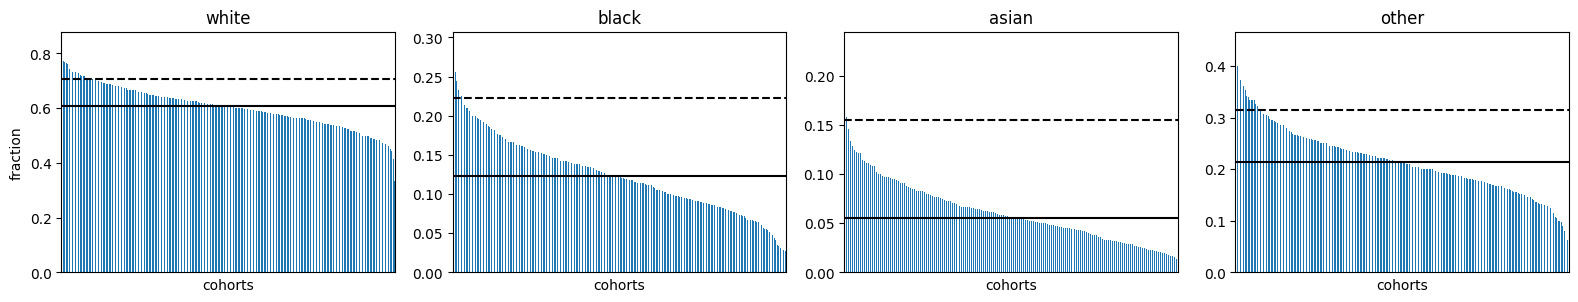

In [79]:
k_values = [2000, 1000, 500, 250, 125, 100, 50, 40, 35, 32, 31, 30]

for k in k_values:
    print('\nk=%s ---------------------------\n' % k)
    cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=k)
    panel_df['cohort'] = panel_df.simhash.map(cohorts_dict)
    show_panel_info(panel_df)
    

## Precompute cohorts

Using cohort size of k = 32 (in order to best match the OT ratio for k:|C|)

In [80]:
# computing cohort IDs for panels in parallel jobs
# since each panel's data is independent for cohort computation
# and this is slow...

from joblib import Parallel, delayed

N_JOBS = 5
k = 32

panel_ids = all_panels_df.panel_id.unique()

def assign_cohorts(panels_df, panel_id, k=k):
    panel_df = panels_df[panels_df.panel_id==panel_id].copy()
    panel_df['cohort'] = np.nan # preset all cohorts to None
    cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=k)
    assign_cohort = lambda x: cohorts_dict[x.simhash] if x.panel_id == panel_id else x['cohort']
    panel_df['cohort'] = panel_df.apply(assign_cohort, axis=1)
    return panel_df

panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
    all_panels_df, panel_id) for panel_id in panel_ids)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   15.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   56.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  2.3min finished


Check this looks okay

In [81]:
print(len(panel_dfs))

520


In [82]:
all_panels_cohort_df = pd.concat(panel_dfs)
all_panels_cohort_df.head()

,machine_id,week,n_domains,racial_background,stratify,panel_id,simhash,cohort
0,213178388,1,16,1.0,1,1,719106496029613,287
1,216240112,1,12,1.0,1,1,598160697020766,233
2,130024050,1,9,1.0,1,1,162797164964515,65
3,231314694,1,17,1.0,1,1,299343367909001,121
4,180222123,1,50,1.0,1,1,818302821507029,340


502 total cohorts
|C| / k = 15.688
cohort sizes:
count    502.000000
mean      51.679283
std       15.582461
min       32.000000
25%       39.000000
50%       48.000000
75%       61.000000
max      107.000000
Name: cohort, dtype: float64


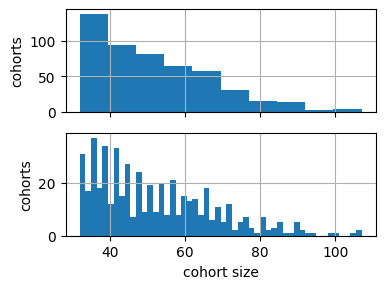

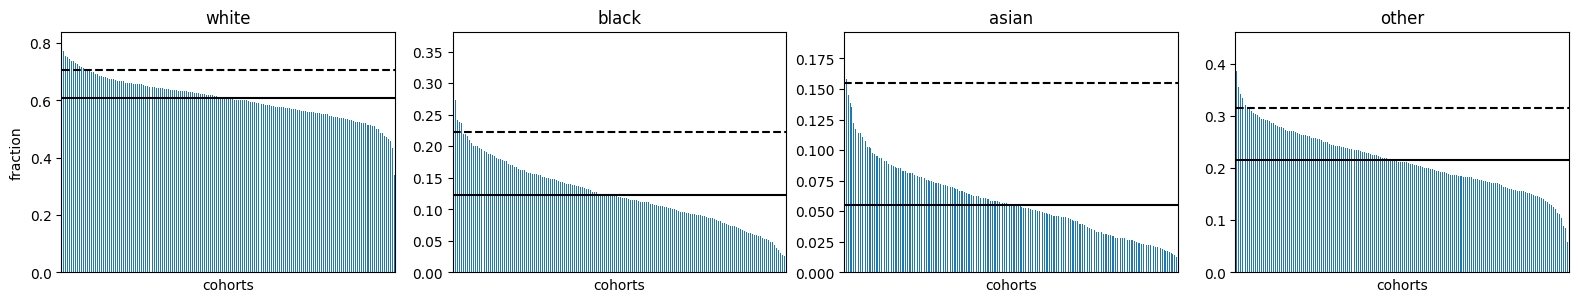

In [83]:
panel_df = all_panels_cohort_df[all_panels_cohort_df.panel_id==4]
show_panel_info(panel_df)

In [84]:
all_panels_df = all_panels_cohort_df

### save cohorts output

In [85]:
comscore_acs_race_panels_cohorts_fpath = '../output/comscore_acs_race_panels_cohorts.csv'

In [ ]:
print('saving to %s...' % comscore_acs_race_panels_cohorts_fpath)
all_panels_df.to_csv(comscore_acs_race_panels_cohorts_fpath, index=False)

Also compute cohort IDs for other k, for experimentation later?

In [ ]:
# k_values = [30, 32, 35, 40, 50]

# for k in k_values:
#     cohort_str = 'cohort_k%s'%k
#     print('computing cohorts for k=%s, column: %s' % (k, cohort_str))
#     # preset all cohorts to None
#     all_panels_df[cohort_str] = np.nan

#     t_start = datetime.now()
#     print('starting at %s' % t_start)
#     for panel_id in all_panels_df.panel_id.unique():
#         t_start = datetime.now()
#         if panel_id % 1 == 0:
#             print('computing cohorts for panel %s/%s' % (panel_id, all_panels_df.panel_id.nunique()))
#         panel_df = all_panels_df[all_panels_df.panel_id==panel_id]
#         cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=k)
#         assign_cohort = lambda x: cohorts_dict[x.simhash] if x.panel_id == panel_id else x[cohort_str]
#         all_panels_df[cohort_str] = all_panels_df.apply(assign_cohort, axis=1)
#         if panel_id % 1 == 0:
#             print('took %s' % (datetime.now() - t_start))
#     print('computed all cohorts for %s after %s' % (cohort_str, (datetime.now() - t_start)))